In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio


In [148]:
path = '../Data/new_sjogren_file/'
patient_data = defaultdict(pd.DataFrame)
for file in os.listdir(path):
    df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
    v, j, c = df.get_mature_usage()
    v1, j1, c1 = df.get_naive_usage()
    mature_data = j / j.sum()
    naive_data = j1 / j1.sum()
    # Combine the data into a single DataFrame
    df = pd.DataFrame({'Naive Repertoire': naive_data, 'Mature Repertoire': mature_data})
    patient_data[file.split('_')[0]] = df

dataframes = []
for patient, repertoires in patient_data.items():
    dataframes.append(repertoires)

combined_df = pd.concat(dataframes)

# # Plot the data as a bar graph
# ax = df.plot(kind='bar', figsize=(12, 6), rot=45, width=0.8)
#
# # Customize the plot
# plt.title("IGHV Gene Usage in Naive and Mature Repertoires")
# plt.xlabel("IGHV Gene Types")
# plt.ylabel("Normalized Counts")
# plt.legend(title='Repertoire')
#
# # Show the plot
# plt.tight_layout()
# plt.show()

In [155]:
a = preprocessing(pd.read_csv('../Data/new_sjogren_file/S8_add_d_gene.tsv', sep='\t'))
a()['productive'].unique()

array(['T'], dtype=object)

In [151]:
data = combined_df.groupby('j_call').agg(['mean', 'std'])
combined_df

,Naive Repertoire,Mature Repertoire
j_call,,
IGHJ4,0.499389,0.615146
IGHJ6,0.188200,0.140564
IGHJ3,0.159182,0.106091
IGHJ5,0.107550,0.100046
IGHJ2,0.028440,0.024155
...,...,...
IGHJ6,0.202155,0.157866
IGHJ3,0.135396,0.124605
IGHJ5,0.121341,0.120751


In [147]:

# Extract data
v_calls = data.index
naive_mean = data[('Naive Repertoire', 'mean')]
naive_std = data[('Naive Repertoire', 'std')]
mature_mean = data[('Mature Repertoire', 'mean')]
mature_std = data[('Mature Repertoire', 'std')]

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35

x = np.arange(len(v_calls))

naive_bars = ax.bar(x - bar_width / 2, naive_mean, bar_width, yerr=naive_std, label='Naive Repertoire', capsize=5)
mature_bars = ax.bar(x + bar_width / 2, mature_mean, bar_width, yerr=mature_std, label='Mature Repertoire', capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(v_calls, rotation=90)

ax.set_xlabel('Jgenes')
ax.set_ylabel('Percentage')
ax.set_title('J gene usage in naive and mature repertoires (patients)')

ax.legend()

plt.tight_layout()
plt.show()


AttributeError: 'collections.defaultdict' object has no attribute 'index'

In [17]:
def vj_gene_usage(dataframe, index):
    j_counts = dataframe.groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
    v_genes = j_counts.index.to_list()
    j_genes = j_counts.apply(lambda x: x[0]).to_list()
    counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

    vj_gene_usage = {}
    for i, v_gene in enumerate(v_genes):
        vj_gene_usage_dict = {jgene: count for jgene, count in zip(j_genes[i], counts[i])}
        vj_gene_usage[v_gene] = vj_gene_usage_dict

    df = pd.DataFrame.from_dict(vj_gene_usage, orient='index')
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reindex(sorted(index), axis=0)
    #df = df.fillna(0)
    df_normalized = df.div(df.sum(axis=1).sum())

    return df_normalized
def shared_diff_genes(path, threshold):
    vj_genes = defaultdict(list)

    for file in os.listdir(path):
        df = pd.read_csv(os.path.join(path, file), sep='\t')
        dataframe = preprocessing(df)
        index = dataframe()['v_call'].unique()

        df_naive = vj_gene_usage(dataframe.get_naive(), index)
        df_mature = vj_gene_usage(dataframe.get_mature(), index)

        df_naive.replace(0, 0.0001, inplace=True)
        df_mature.replace(0, 0.0001, inplace=True)

        df_change = df_mature - df_naive

        for row in df_change.iterrows():
            for col in df_change.columns:
                if  row[1][col] > threshold:
                    vj_genes[file].append([row[0], col])

    shared_genes =  defaultdict(int)
    for patient, gene in vj_genes.items():
        for gene_pair in gene:
            str_gene_pair = gene_pair[0] + '|' + gene_pair[1]
            if str_gene_pair not in shared_genes.keys():
                shared_genes[str_gene_pair] = 1
            else:
                shared_genes[str_gene_pair] += 1
    return shared_genes
def multiple_shared_diff_genes(dict, threshold):
    output_dict = defaultdict(int)
    for gene, degree in dict.items():
        if degree > threshold:
            output_dict[gene] = degree
    return output_dict

In [59]:
sjogren_path = '../Data/new_sjogren_file/'
healthy_path = '../Data/in_house_healthy/'

# sjogren_shared = shared_diff_genes(sjogren_path, math.log10(2))
# healthy_shared = shared_diff_genes(healthy_path, math.log10(2))

In [62]:
FoldChange_sjogren = defaultdict(dict)
FoldChange_healthy = defaultdict(dict)
for file in os.listdir(sjogren_path):
    df = preprocessing(pd.read_csv(os.path.join(sjogren_path, file), sep='\t'))
    index = df()['v_call'].unique()
    mature = df.get_mature()
    naive = df.get_naive()
    FC = np.log2(vj_gene_usage(mature, index) / vj_gene_usage(naive, index))
    FC_dict = {}
    for i, row in FC.iterrows():
        for column in row.index:
            if pd.notna(row[column]):
                FC_dict[(row.name, column)] = row[column]
    FoldChange_sjogren[file.split('_')[0]] = FC_dict

for file in os.listdir(healthy_path):
    df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))
    index = df()['v_call'].unique()
    mature = df.get_mature()
    naive = df.get_naive()
    FC = np.log2(vj_gene_usage(mature, index) / vj_gene_usage(naive, index))
    FC_dict = {}
    for i, row in FC.iterrows():
        for column in row.index:
            if pd.notna(row[column]):
                FC_dict[(row.name, column)] = row[column]
    FoldChange_healthy[file.split('_')[0]] = FC_dict

In [145]:

data = FoldChange_sjogren

FoldChange = defaultdict(list)
for keys, items in data.items():
    for key, item in  items.items():
        FoldChange[key].append(item)

null_mean = 0.0
p_values = {}

for vj_pair, fold_changes in FoldChange.items():
    if np.var(fold_changes) == 0:
        p_value = 1.0
    else:
        t_stat, p_value = stats.ttest_1samp(fold_changes, null_mean)
    p_values[vj_pair] = p_value

volcano_plot = pd.DataFrame()
FC_dataframe = pd.DataFrame.from_dict(FoldChange, orient='index')
volcano_plot['mean'] = FC_dataframe.mean(axis=1)
volcano_plot['p-value'] = p_values.values()
volcano_plot['std'] = FC_dataframe.std(axis=1)
volcano_plot['-log10(p-value)'] = -np.log10(volcano_plot['p-value'])

volcano_plot.dropna(inplace=True)

def draw_volcano_plot(df):
    df = volcano_plot.copy()
    significance_threshold = 0.05
    threshold_2 = 0.01
    threshold_3 = 0.001

    plt.figure(figsize=(10, 6))
    plt.scatter(df['mean'], df['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='b', alpha=0.5)

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]
    significant_points_1 = df[df['p-value'] < threshold_2]
    significant_points_2 = df[df['p-value'] < threshold_3]
    plt.scatter(significant_points['mean'], significant_points['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='r', marker='o', label='Significant')

    # Add labels and title
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(P-Value)')
    plt.title('Fold Change for Unique VJ Pair')

    # Add significance threshold line
    plt.axhline(-np.log10(significance_threshold), color='g', linestyle='--', label='p = 0.05')
    plt.axhline(-np.log10(threshold_2), color='b', linestyle='--', label='p = 0.01')
    plt.axhline(-np.log10(threshold_3), color='r', linestyle='--', label='p = 0.001')

    # Add VJ_pair labels
    for i, row in significant_points_2.iterrows():
        plt.annotate(row.name[0] + '|' + row.name[1], (row['mean'], row['-log10(p-value)']))

    plt.legend()
    plt.show()

def interactive_volcano_plot(df):
    df = volcano_plot.copy()
    significance_threshold = 0.05
    df['vj_pair'] = df.index

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]

    fig = px.scatter(
    significant_points,
    x='mean',
    y='-log10(p-value)',
    hover_data=['vj_pair', 'p-value', 'std'],
    labels={'-log10(p-value)': '-log10(p-value)'},
    title='Fold Change (naive : mature)',
    )

# Add significance threshold line
    fig.add_shape(
        go.layout.Shape(
            type='line',
            x0=df['mean'].min(),
            x1=df['mean'].max(),
            y0=-np.log10(significance_threshold),
            y1=-np.log10(significance_threshold),
            line=dict(color='green', dash='dash'),
        )
    )
    #pio.write_html(fig, file='volcano_plot_healthy_interactive.html')
    fig.show()

FC_dataframe.count(axis=1)


(IGHV1-18, IGHJ1)      20
(IGHV1-18, IGHJ2)      20
(IGHV1-18, IGHJ3)      20
(IGHV1-18, IGHJ4)      20
(IGHV1-18, IGHJ5)      20
                       ..
(IGHV5-10-1, IGHJ1)     8
(IGHV1-69-2, IGHJ4)     2
(IGHV1-69-2, IGHJ6)     1
(IGHV4-28, IGHJ1)       1
(IGHV1-69-2, IGHJ5)     1
Length: 290, dtype: int64

In [227]:
sjogren_multiple_shared = multiple_shared_diff_genes(sjogren_shared, 4)
healthy_multiple_shared = multiple_shared_diff_genes(healthy_shared, 1)
only_in_sjogren = set(sjogren_multiple_shared.keys()) - set(healthy_multiple_shared.keys())

vj_genes_for_qualification = []
for gene in only_in_sjogren:
    vj_genes_for_qualification.append([gene.split('|')[0], gene.split('|')[1]])
vj_genes_for_qualification

{'IGHV1-18|IGHJ6',
 'IGHV1-24|IGHJ3',
 'IGHV1-45|IGHJ4',
 'IGHV1-58|IGHJ5',
 'IGHV1-8|IGHJ3',
 'IGHV2-5|IGHJ5',
 'IGHV2-70|IGHJ2',
 'IGHV2-70|IGHJ4',
 'IGHV3-15|IGHJ6',
 'IGHV3-21|IGHJ3',
 'IGHV3-21|IGHJ4',
 'IGHV3-30-3|IGHJ2',
 'IGHV3-33|IGHJ4',
 'IGHV3-43D|IGHJ3',
 'IGHV3-43|IGHJ4',
 'IGHV3-64D|IGHJ6',
 'IGHV3-NL1|IGHJ3',
 'IGHV3-NL1|IGHJ5',
 'IGHV4-30-2|IGHJ5',
 'IGHV4-30-2|IGHJ6',
 'IGHV4-31|IGHJ4',
 'IGHV4-34|IGHJ2',
 'IGHV4-38-2|IGHJ6',
 'IGHV4-39|IGHJ1',
 'IGHV4-59|IGHJ5',
 'IGHV4-61|IGHJ2',
 'IGHV4-61|IGHJ4',
 'IGHV5-10-1|IGHJ2',
 'IGHV5-10-1|IGHJ5',
 'IGHV7-4-1|IGHJ2',
 'IGHV7-4-1|IGHJ5'}

In [229]:
path =  '../Data/new_sjogren_file/'
files = os.listdir(path)

fold_change_matrix = defaultdict(list)

for file in files:
    df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
    index = df()['v_call'].unique()

    df_naive = vj_gene_usage(df.get_naive(), index)
    df_mature = vj_gene_usage(df.get_mature(), index)
    df_naive.replace(0, 0.000001, inplace=True)
    df_naive = np.log10(df_naive)
    df_mature.replace(0, 0.000001, inplace=True)
    df_mature = np.log10(df_mature)
    df_change = df_mature - df_naive

    for vj_gene in vj_genes_for_qualification:
        if (vj_gene[0] in df_change.index) & (vj_gene[1] in df_change.columns):
            if df_change[vj_gene[1]][vj_gene[0]] > 1:
                fold_change_matrix[vj_gene[0] + '|' + vj_gene[1]].append(df_change[vj_gene[1]][vj_gene[0]])

In [230]:
path =  '../Data/in_house_healthy/'
files = os.listdir(path)

fold_change_matrix_control = defaultdict(list)

for file in files:
    df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
    index = df()['v_call'].unique()

    df_naive = vj_gene_usage(df.get_naive(), index)
    df_mature = vj_gene_usage(df.get_mature(), index)
    df_naive.replace(0, 0.000001, inplace=True)
    df_naive = np.log10(df_naive)
    df_mature.replace(0, 0.000001, inplace=True)
    df_mature = np.log10(df_mature)
    df_change = df_mature - df_naive

    for vj_gene in vj_genes_for_qualification:
        if (vj_gene[0] in df_change.index) & (vj_gene[1] in df_change.columns):
            if df_change[vj_gene[1]][vj_gene[0]] != 0:
                fold_change_matrix_control[vj_gene[0] + '|' + vj_gene[1]].append(df_change[vj_gene[1]][vj_gene[0]])

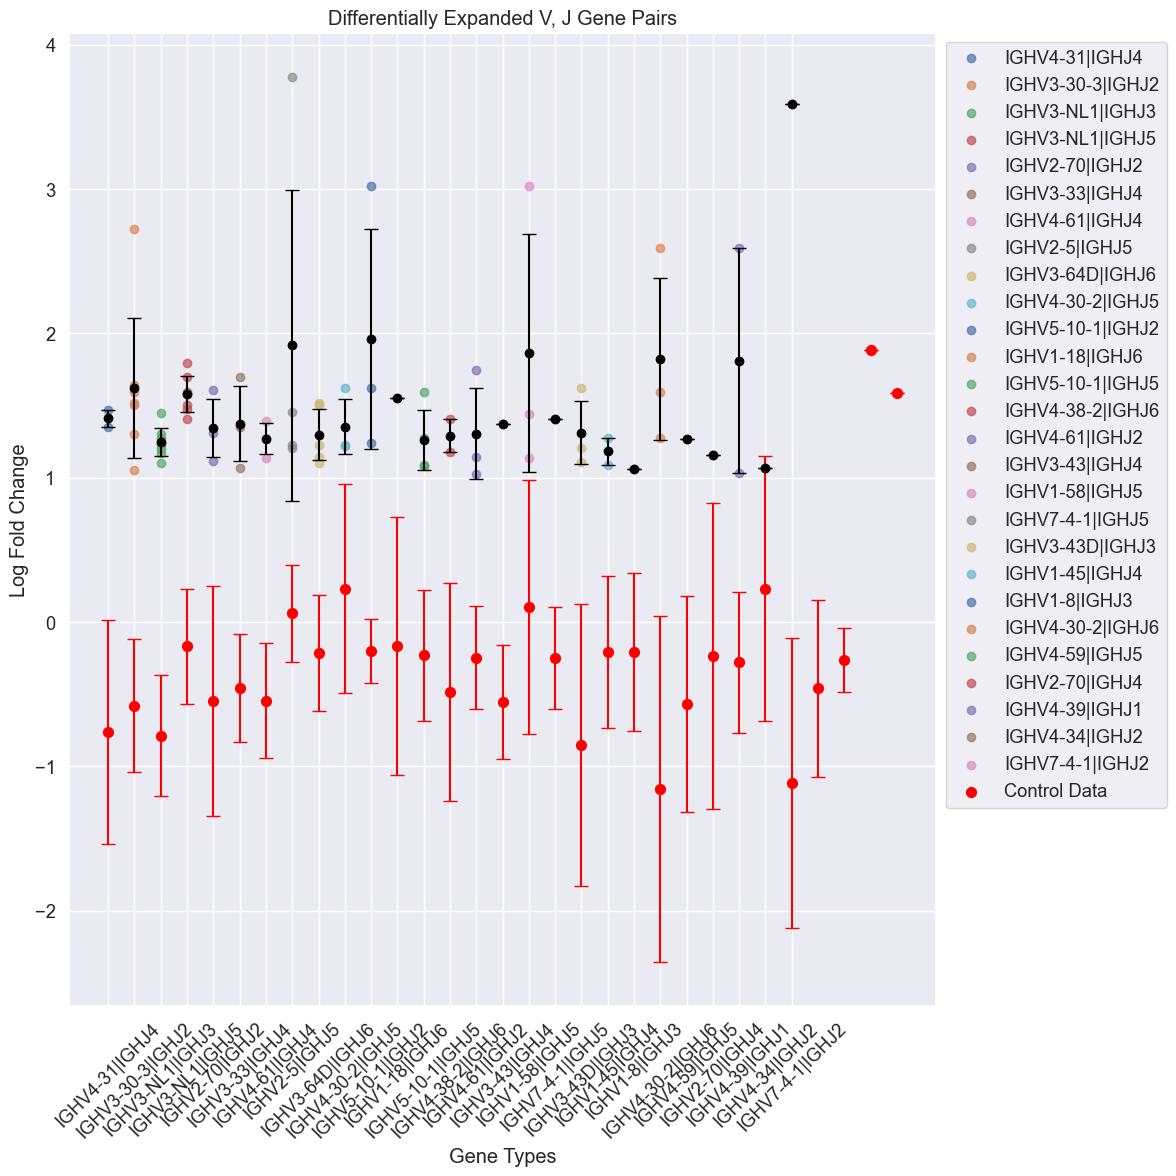

In [232]:
control_gene_types = list(fold_change_matrix_control.keys())
control_data_values = list(fold_change_matrix_control.values())

control_means = [np.mean(values) for values in control_data_values]
control_std = [np.std(values) for values in control_data_values]

experimental_gene_types = list(fold_change_matrix.keys())
experimental_data_values = list(fold_change_matrix.values())

plt.figure(figsize=(12, 12))
ax = plt.gca()

for i, values in enumerate(experimental_data_values):
    x = [i] * len(values)
    y = values
    plt.scatter(x, y, label=experimental_gene_types[i], marker='o', alpha=0.7)
    plt.errorbar(i, np.mean(y), yerr=np.std(y), color='black', fmt='o', capsize=5)

plt.scatter(range(len(control_gene_types)), control_means, label="Healthy Control", marker='o', color='red', s=50)

for i, mean_value in enumerate(control_means):
    plt.errorbar(i, mean_value, yerr=control_std[i], color='red', fmt='o', capsize=5)

plt.title("Differentially Expanded V, J Gene Pairs")
plt.xlabel("Gene Types")
plt.ylabel("Log Fold Change")
plt.xticks(range(len(experimental_gene_types)), experimental_gene_types, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


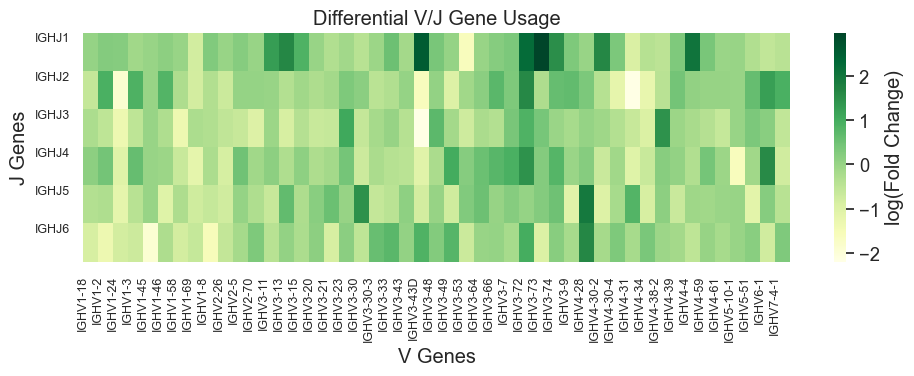

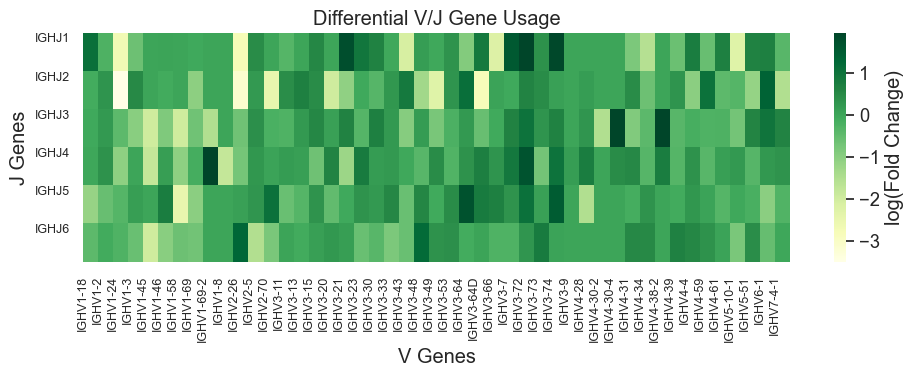

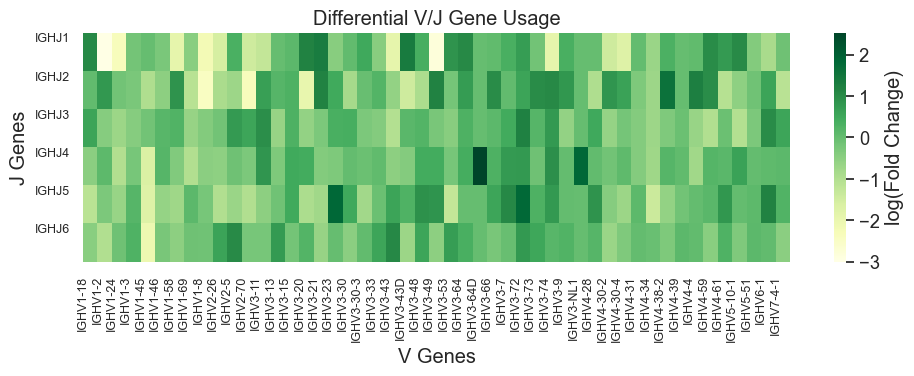

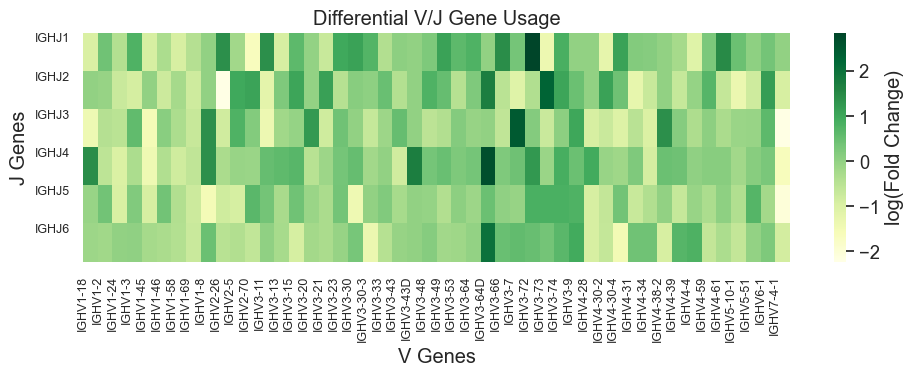

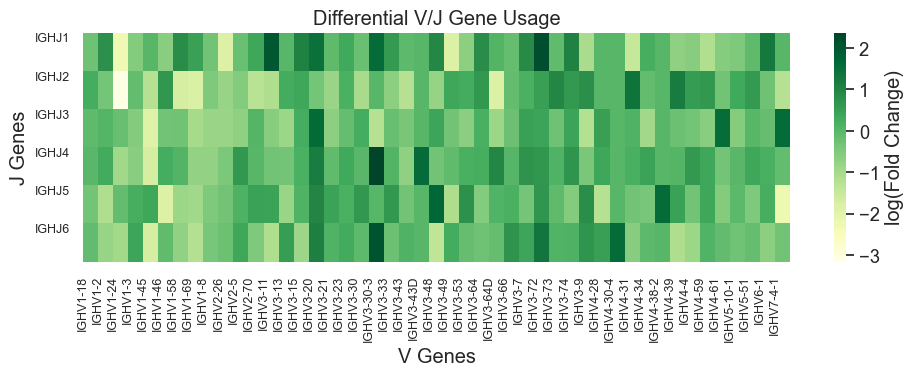

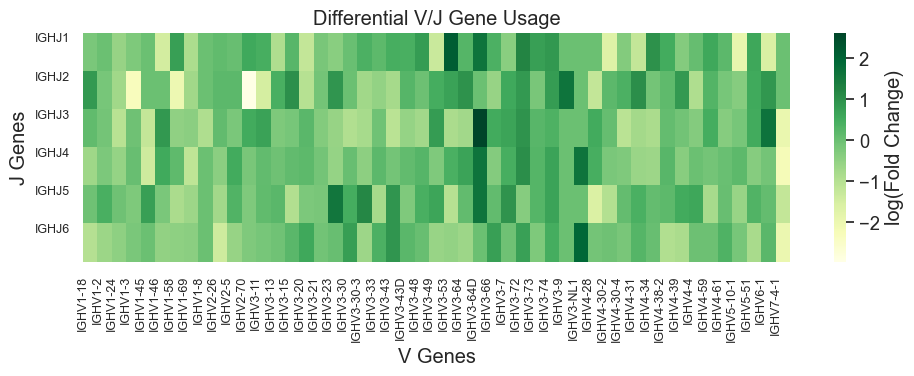

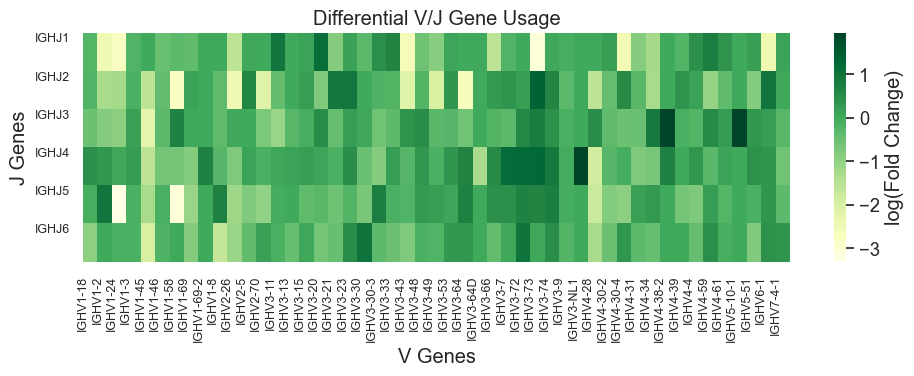

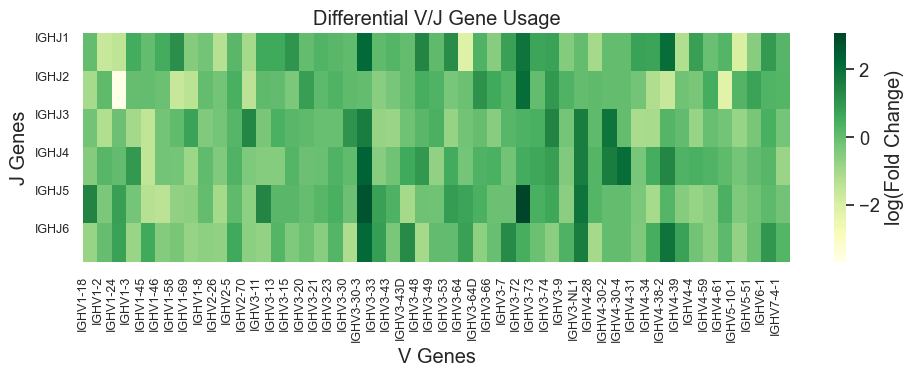

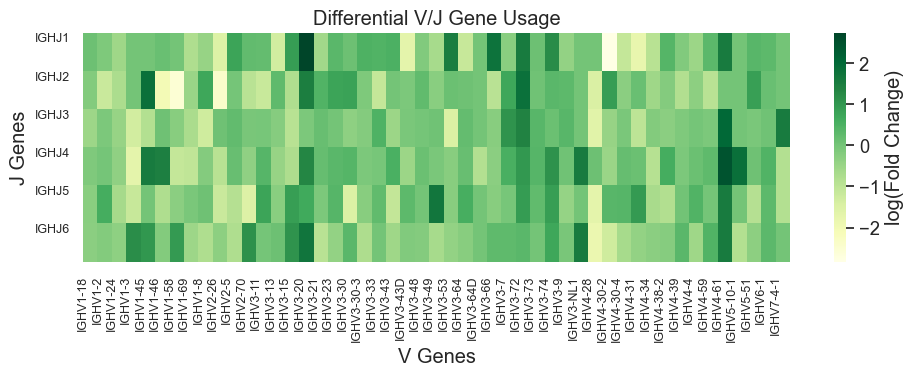

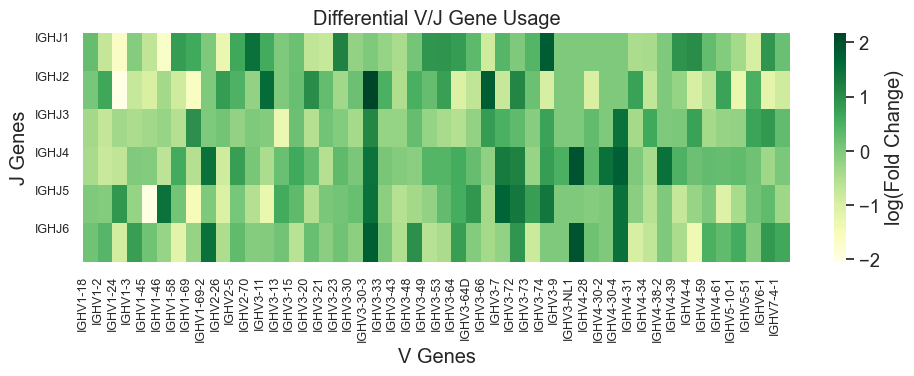

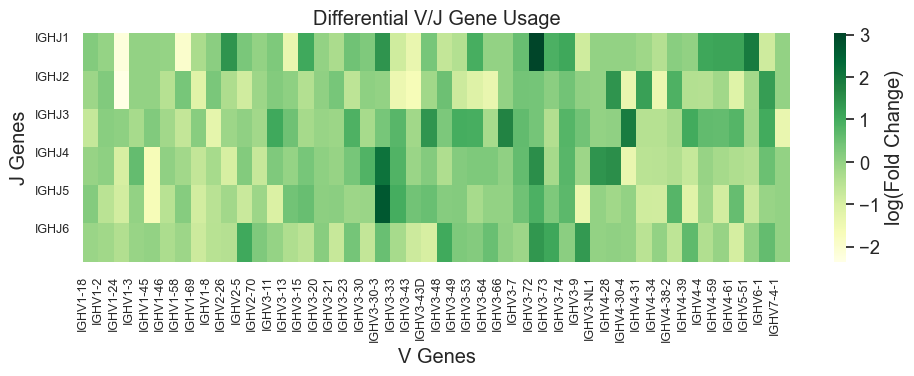

In [75]:
path =  '../Data/in_house_healthy/'
files = os.listdir(path)

for file in files:
    df = pd.read_csv(os.path.join(path, file), sep='\t')
    dataframe = preprocessing(df)
    index = dataframe()['v_call'].unique()

    df_naive = vj_gene_usage(dataframe.get_naive(), index)
    df_mature = vj_gene_usage(dataframe.get_mature(), index)

    df_naive.replace(0, 0.000001, inplace=True)
    df_naive = np.log10(df_naive)

    df_mature.replace(0, 0.000001, inplace=True)
    df_mature = np.log10(df_mature)

    df_change = df_mature - df_naive

    plt.figure(figsize=(10, 4))
    sns.set(font_scale = 1.2)
    sns.heatmap(df_change.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'log(Fold Change)'})

    plt.title('Differential V/J Gene Usage')
    plt.xlabel('V Genes')
    plt.ylabel('J Genes', rotation=90)

    ax = plt.gca()
    ax.set_xticks(range(len(df_change.index)))
    ax.set_xticklabels(df_change.index, fontsize = 9, ha='center')

    ax.set_yticks(range(len(df_change.columns)))
    ax.set_yticklabels(df_change.columns, rotation=0, va='top', fontsize = 9)

    plt.tight_layout()
    plt.savefig(f'../Data/diff_usage_healthy/{file.split(".")[0]}_differential_v_j_gene_usage.png', dpi=500)

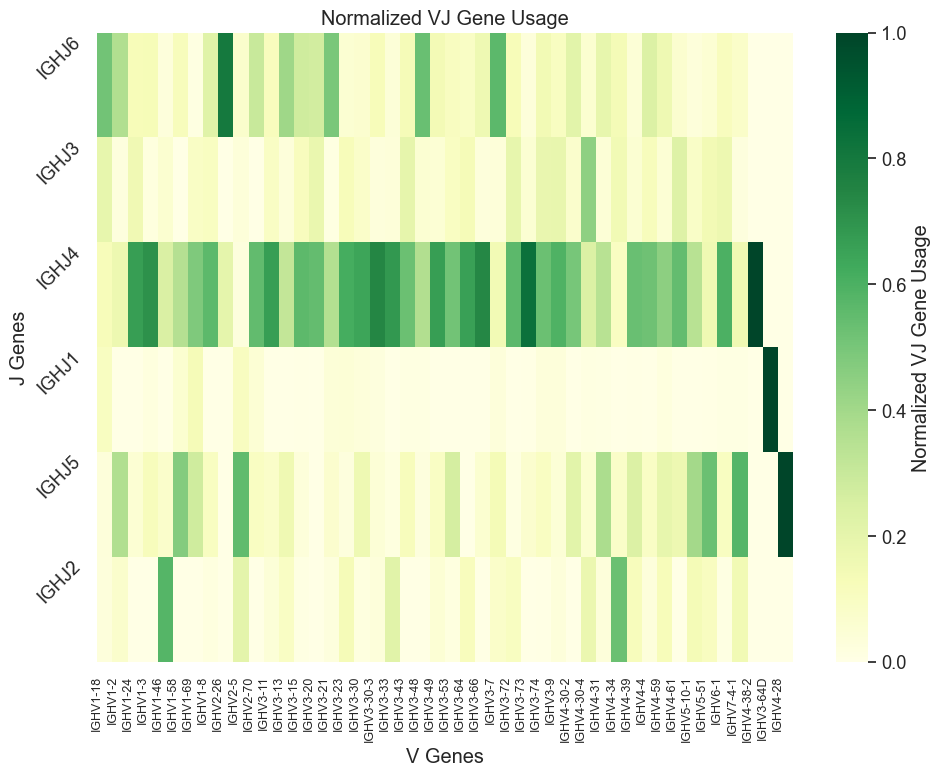

In [6]:
j_counts = dataframe.get_mature().groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
v_genes = j_counts.index.to_list()
j_genes = j_counts.apply(lambda x: x[0]).to_list()
counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

vj_gene_usage = {}
for i, v_gene in enumerate(v_genes):
    vj_gene_usage_dict = {isotype: count for isotype, count in zip(j_genes[i], counts[i])}
    vj_gene_usage[v_gene] = vj_gene_usage_dict

df = pd.DataFrame.from_dict(vj_gene_usage, orient='index').fillna(0)

df_normalized = df.div(df.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.2)
sns.heatmap(df_normalized.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'Normalized VJ Gene Usage'})

plt.title('Normalized VJ Gene Usage')
plt.xlabel('V Genes')
plt.ylabel('J Genes', rotation=90)

ax = plt.gca()
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, fontsize = 9)

ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns, rotation=45, va='top')

plt.tight_layout()
plt.show()

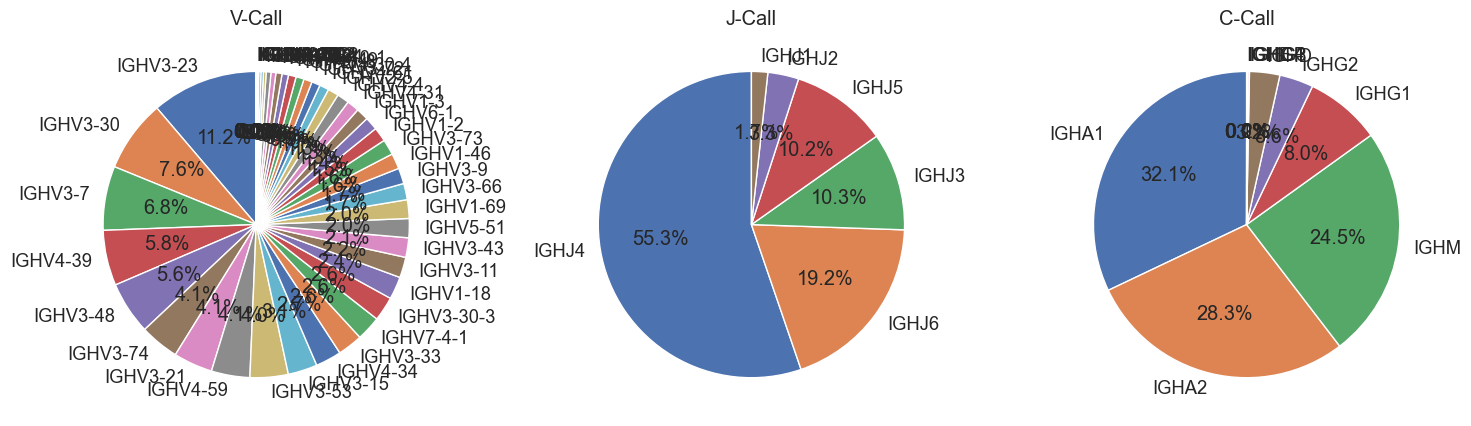

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(cluster_S8.dataframe['v_call'].value_counts(), labels=cluster_S8.dataframe['v_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('V-Call')
axes[1].pie(cluster_S8.dataframe['j_call'].value_counts(), labels=cluster_S8.dataframe['j_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('J-Call')
axes[2].pie(cluster_S8.dataframe['c_call'].value_counts(), labels=cluster_S8.dataframe['c_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('C-Call')

plt.tight_layout()
plt.savefig('../Data/Example/pie_chart.png', dpi=300)

count    9132.000000
mean      298.831143
std        11.910628
min       246.000000
25%       291.000000
50%       298.000000
75%       307.000000
max       357.000000
Name: sequence_alignment, dtype: float64

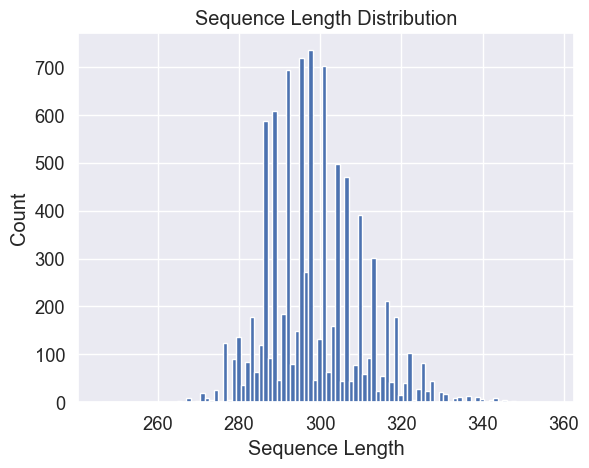

In [175]:
sequence_length = S8['sequence_alignment'].str.len()
sequence_length.hist(bins=100)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.savefig('../Data/Example/sequence_length.png', dpi=300)
sequence_length.describe()

count    9132.000000
mean       14.314936
std         3.702971
min         2.000000
25%        12.000000
50%        14.000000
75%        17.000000
max        29.000000
Name: cdr3_aa_len, dtype: float64

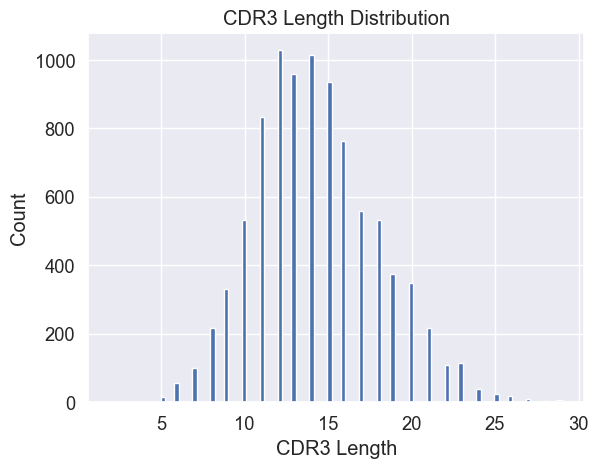

In [176]:
cdr3_length = cluster_S8.dataframe['cdr3_aa_len']
cdr3_length.hist(bins=100)
plt.title('CDR3 Length Distribution')
plt.xlabel('CDR3 Length')
plt.ylabel('Count')
plt.savefig('../Data/Example/cdr3_length.png', dpi=300)
cdr3_length.describe()

In [177]:
recombination_types = recombinations(S8)
CSRtypes = recombination_types()

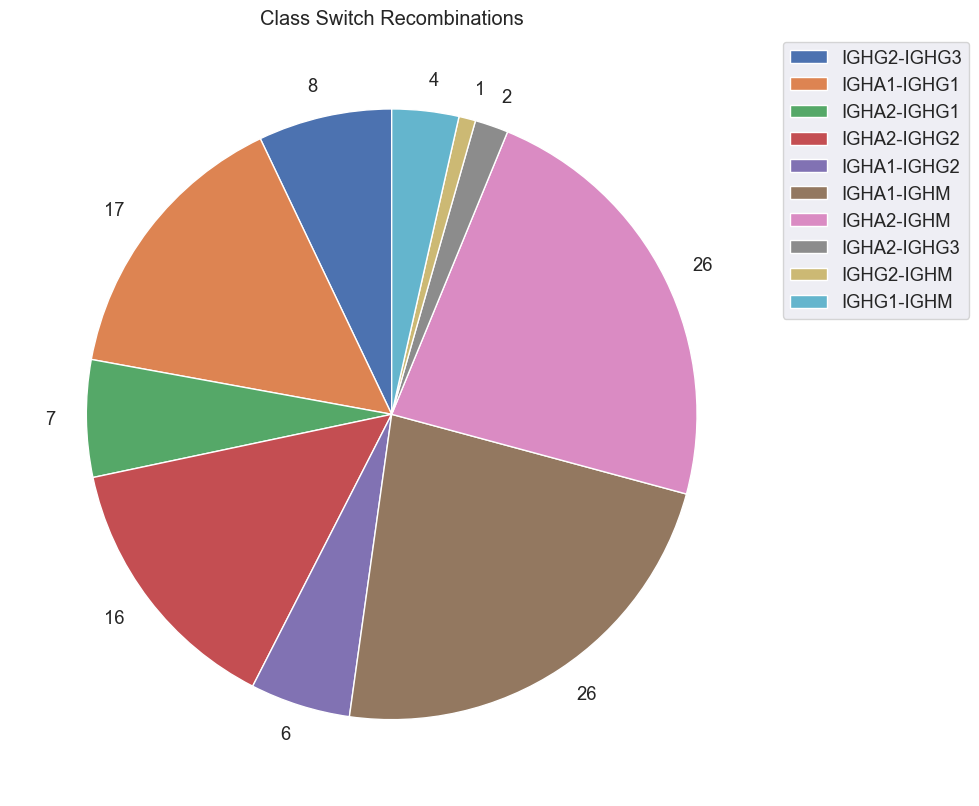

In [178]:
types = []
freq = []

for t, f in CSRtypes.items():
    types.append(t)
    freq.append(f)

plt.figure(figsize = (10,10))
plt.pie(freq, labels = freq, startangle=90)
plt.legend(labels = types, loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('Class Switch Recombinations')
plt.savefig('../Data/Example/CSR_types.png', dpi=300)